# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "module_name": "kgcnn.literature.Schnet", 
    "class_name":"make_model", 
    "output_as_dict":True,
    "config":{
        "name": "Schnet",
        "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                   {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                   {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
        "make_distance": True, "expand_distance": True,
        "interaction_args": {"units": 128, "use_bias": True,
                             "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
        "node_pooling_args": {"pooling_method": "sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
        "verbose": 10,
        "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                     "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
        "output_embedding": "graph", "output_to_tensor": True,
        "use_output_mlp": True,
        "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                       "activation": ["kgcnn>shifted_softplus", "linear"]}},
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model.model_config["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 4s 28ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 19.0034 - energy_loss: 0.2749 - force_loss: 0.9364 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9403 - energy_loss: 0.2174 - force_loss: 0.9361 - 540ms/epoch - 68ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9203 - energy_loss: 0.2061 - force_loss: 0.9357 - 532ms/epoch - 67ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8963 - energy_loss: 0.2087 - force_loss: 0.9344 - 538ms/epoch - 67ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.7999 - energy_loss: 0.2241 - force_loss: 0.9288 - 535ms/epoch - 67ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.6318 - energy_loss: 0.3287 - force_loss: 0.9152 - 525ms/epoch - 66ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.4733 - energy_loss: 0.4374 - force_loss: 0.9018 - 529ms/epoch - 66ms/step
Epoch 8/1500
8/8 - 1s - loss: 18.0064 - energy_loss: 0.4369 - force_loss: 0.8785 - 527ms/epoch - 66ms/step
Epoch 9/1500
8/8 - 1s - loss: 17.2109 - energy_loss: 0.6542 - force_loss: 0.8278 - 526ms/epoch - 66ms/step
Epoch 10/1500
8/8 - 1s - loss: 16.5517 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.2303 - energy_loss: 0.7761 - force_loss: 0.2727 - 560ms/epoch - 70ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.0376 - energy_loss: 0.7633 - force_loss: 0.2637 - 547ms/epoch - 68ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.1591 - energy_loss: 0.7620 - force_loss: 0.2699 - 555ms/epoch - 69ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.1664 - energy_loss: 0.8171 - force_loss: 0.2675 - 547ms/epoch - 68ms/step
Epoch 82/1500
8/8 - 1s - loss: 5.9833 - energy_loss: 0.7949 - force_loss: 0.2594 - 565ms/epoch - 71ms/step
Epoch 83/1500
8/8 - 1s - loss: 5.8587 - energy_loss: 0.7557 - force_loss: 0.2551 - 532ms/epoch - 66ms/step
Epoch 84/1500
8/8 - 1s - loss: 5.8386 - energy_loss: 0.7799 - force_loss: 0.2529 - 550ms/epoch - 69ms/step
Epoch 85/1500
8/8 - 1s - loss: 5.7955 - energy_loss: 0.7917 - force_loss: 0.2502 - 542ms/epoch - 68ms/step
Epoch 86/1500
8/8 - 1s - loss: 5.6819 - energy_loss: 0.8021 - force_loss: 0.2440 - 552ms/epoch - 69ms/step
Epoch 87/1500
8/8 - 1s - loss: 5.5966

8/8 - 1s - loss: 4.2033 - energy_loss: 0.5922 - force_loss: 0.1806 - 531ms/epoch - 66ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.2318 - energy_loss: 0.6342 - force_loss: 0.1799 - 551ms/epoch - 69ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.2184 - energy_loss: 0.6385 - force_loss: 0.1790 - 669ms/epoch - 84ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.1050 - energy_loss: 0.6189 - force_loss: 0.1743 - 583ms/epoch - 73ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.0462 - energy_loss: 0.6198 - force_loss: 0.1713 - 546ms/epoch - 68ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.0848 - energy_loss: 0.6230 - force_loss: 0.1731 - 538ms/epoch - 67ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.1605 - energy_loss: 0.6105 - force_loss: 0.1775 - 530ms/epoch - 66ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.3649 - energy_loss: 0.6371 - force_loss: 0.1864 - 634ms/epoch - 79ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.2288 - energy_loss: 0.6481 - force_loss: 0.1790 - 548ms/epoch - 69ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.0245 - en

Epoch 230/1500
8/8 - 1s - loss: 3.0742 - energy_loss: 0.2719 - force_loss: 0.1401 - 528ms/epoch - 66ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.0567 - energy_loss: 0.2465 - force_loss: 0.1405 - 540ms/epoch - 68ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.9249 - energy_loss: 0.9842 - force_loss: 0.1470 - 544ms/epoch - 68ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.6173 - energy_loss: 0.5614 - force_loss: 0.1528 - 546ms/epoch - 68ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.5778 - energy_loss: 0.5309 - force_loss: 0.1523 - 603ms/epoch - 75ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.7475 - energy_loss: 0.4957 - force_loss: 0.1626 - 569ms/epoch - 71ms/step
Epoch 236/1500
8/8 - 1s - loss: 4.0846 - energy_loss: 0.9205 - force_loss: 0.1582 - 537ms/epoch - 67ms/step
Epoch 237/1500
8/8 - 1s - loss: 4.0866 - energy_loss: 0.9579 - force_loss: 0.1564 - 531ms/epoch - 66ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.6995 - energy_loss: 0.5415 - force_loss: 0.1579 - 536ms/epoch - 67ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.1024 - energy_loss: 0.5252 - force_loss: 0.1289 - 530ms/epoch - 66ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.3438 - energy_loss: 0.5299 - force_loss: 0.1407 - 535ms/epoch - 67ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.4160 - energy_loss: 0.5064 - force_loss: 0.1455 - 526ms/epoch - 66ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.4893 - energy_loss: 0.5415 - force_loss: 0.1474 - 525ms/epoch - 66ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.2728 - energy_loss: 0.5275 - force_loss: 0.1373 - 527ms/epoch - 66ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.0449 - energy_loss: 0.4930 - force_loss: 0.1276 - 532ms/epoch - 66ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.1016 - energy_loss: 0.4957 - force_loss: 0.1303 - 587ms/epoch - 73ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.1430 - energy_loss: 0.4840 - force_loss: 0.1329 - 548ms/epoch - 69ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.0926 - energy_loss: 0.4963 - force_loss: 0.1298 - 543ms/epoch - 68ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 2.4920 - energy_loss: 0.2199 - force_loss: 0.1136 - 547ms/epoch - 68ms/step
Epoch 383/1500
8/8 - 1s - loss: 2.5184 - energy_loss: 0.2741 - force_loss: 0.1122 - 550ms/epoch - 69ms/step
Epoch 384/1500
8/8 - 1s - loss: 2.9333 - energy_loss: 0.5904 - force_loss: 0.1171 - 558ms/epoch - 70ms/step
Epoch 385/1500
8/8 - 1s - loss: 2.9658 - energy_loss: 0.4919 - force_loss: 0.1237 - 564ms/epoch - 70ms/step
Epoch 386/1500
8/8 - 1s - loss: 2.8965 - energy_loss: 0.5164 - force_loss: 0.1190 - 546ms/epoch - 68ms/step
Epoch 387/1500
8/8 - 1s - loss: 2.7181 - energy_loss: 0.4064 - force_loss: 0.1156 - 532ms/epoch - 67ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.7088 - energy_loss: 0.4146 - force_loss: 0.1147 - 567ms/epoch - 71ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.7631 - energy_loss: 0.4771 - force_loss: 0.1143 - 545ms/epoch - 68ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.6790 - energy_loss: 0.4086 - force_loss: 0.1135 - 624ms/epoch - 78ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.5635 - energy_loss: 0.4569 - force_loss: 0.1053 - 569ms/epoch - 71ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.3753 - energy_loss: 0.2560 - force_loss: 0.1060 - 532ms/epoch - 67ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.3280 - energy_loss: 0.1985 - force_loss: 0.1065 - 539ms/epoch - 67ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.3334 - energy_loss: 0.1855 - force_loss: 0.1074 - 524ms/epoch - 66ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.5174 - energy_loss: 0.3445 - force_loss: 0.1086 - 541ms/epoch - 68ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.3282 - energy_loss: 0.2080 - force_loss: 0.1060 - 582ms/epoch - 73ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.3823 - energy_loss: 0.2406 - force_loss: 0.1071 - 647ms/epoch - 81ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.4759 - energy_loss: 0.3651 - force_loss: 0.1055 - 585ms/epoch - 73ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.5902 - energy_loss: 0.4898 - force_loss: 0.1050 - 667ms/epoch - 83ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.7110 - energy_loss: 0.4092 - force_loss: 0.1151 - 565ms/epoch - 71ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.6888 - energy_loss: 0.4069 - force_loss: 0.1141 - 566ms/epoch - 71ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.7103 - energy_loss: 0.3972 - force_loss: 0.1157 - 550ms/epoch - 69ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.4591 - energy_loss: 0.4079 - force_loss: 0.1026 - 555ms/epoch - 69ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.4845 - energy_loss: 0.4101 - force_loss: 0.1037 - 557ms/epoch - 70ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.4729 - energy_loss: 0.4339 - force_loss: 0.1020 - 565ms/epoch - 71ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.1354 - energy_loss: 0.1654 - force_loss: 0.0985 - 551ms/epoch - 69ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.2923 - energy_loss: 0.2770 - force_loss: 0.1008 - 552ms/epoch - 69ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.5685 - energy_loss: 0.4954 - force_loss: 0.1037 - 529ms/epoch - 66ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.3759 - energy_loss: 0.4382 - force_loss: 0.0969 - 527ms/epoch - 66ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.4306 - energy_loss: 0.4224 - force_loss: 0.1004 - 527ms/epoch - 66ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.4083 - energy_loss: 0.4173 - force_loss: 0.0995 - 546ms/epoch - 68ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.6490 - energy_loss: 0.3969 - force_loss: 0.1126 - 525ms/epoch - 66ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.8888 - energy_loss: 0.3680 - force_loss: 0.1260 - 539ms/epoch - 67ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.5520 - energy_loss: 0.3420 - force_loss: 0.1105 - 522ms/epoch - 65ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.4668 - energy_loss: 0.4404 - force_loss: 0.1013 - 534ms/epoch - 67ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.6290 - energy_loss: 0.3944 - force_loss: 0.1117 - 554ms/epoch - 69ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.9054 - energy_loss: 0.4485 - force_loss: 0.1228 - 530ms/epoch - 66ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.0473 - energy_loss: 0.1532 - force_loss: 0.0947 - 531ms/epoch - 66ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.3202 - energy_loss: 0.3965 - force_loss: 0.0962 - 532ms/epoch - 67ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.3442 - energy_loss: 0.4494 - force_loss: 0.0947 - 527ms/epoch - 66ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.2818 - energy_loss: 0.3980 - force_loss: 0.0942 - 534ms/epoch - 67ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.2340 - energy_loss: 0.3784 - force_loss: 0.0928 - 539ms/epoch - 67ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.2812 - energy_loss: 0.3743 - force_loss: 0.0953 - 539ms/epoch - 67ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.2168 - energy_loss: 0.3647 - force_loss: 0.0926 - 528ms/epoch - 66ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.0378 - energy_loss: 0.2044 - force_loss: 0.0917 - 536ms/epoch - 67ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.2355 - energy_loss: 0.3559 - force_loss: 0.0940 - 544ms/epoch - 68ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 1.8903 - energy_loss: 0.1772 - force_loss: 0.0857 - 547ms/epoch - 68ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.0476 - energy_loss: 0.3492 - force_loss: 0.0849 - 552ms/epoch - 69ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.2511 - energy_loss: 0.4786 - force_loss: 0.0886 - 532ms/epoch - 67ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.5208 - energy_loss: 0.7306 - force_loss: 0.0895 - 535ms/epoch - 67ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.5258 - energy_loss: 0.7022 - force_loss: 0.0912 - 528ms/epoch - 66ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.4716 - energy_loss: 0.5435 - force_loss: 0.0964 - 530ms/epoch - 66ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.2138 - energy_loss: 0.2362 - force_loss: 0.0989 - 525ms/epoch - 66ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.0057 - energy_loss: 0.1674 - force_loss: 0.0919 - 530ms/epoch - 66ms/step
Epoch 770/1500
8/8 - 1s - loss: 1.9980 - energy_loss: 0.1828 - force_loss: 0.0908 - 526ms/epoch - 66ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.3803 - energy_loss: 0.3712 - force_loss: 0.1005 - 551ms/epoch - 69ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.3645 - energy_loss: 0.3731 - force_loss: 0.0996 - 551ms/epoch - 69ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.3746 - energy_loss: 0.4072 - force_loss: 0.0984 - 544ms/epoch - 68ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.2371 - energy_loss: 0.3123 - force_loss: 0.0962 - 538ms/epoch - 67ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.2944 - energy_loss: 0.4038 - force_loss: 0.0945 - 550ms/epoch - 69ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.2675 - energy_loss: 0.4322 - force_loss: 0.0918 - 558ms/epoch - 70ms/step
Epoch 844/1500
8/8 - 1s - loss: 2.5701 - energy_loss: 0.7161 - force_loss: 0.0927 - 537ms/epoch - 67ms/step
Epoch 845/1500
8/8 - 1s - loss: 2.4758 - energy_loss: 0.6344 - force_loss: 0.0921 - 543ms/epoch - 68ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.4740 - energy_loss: 0.5978 - force_loss: 0.0938 - 544ms/epoch - 68ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.1301 - energy_loss: 0.3634 - force_loss: 0.0883 - 524ms/epoch - 66ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.0436 - energy_loss: 0.2088 - force_loss: 0.0917 - 528ms/epoch - 66ms/step
Epoch 916/1500
8/8 - 1s - loss: 1.9076 - energy_loss: 0.1535 - force_loss: 0.0877 - 533ms/epoch - 67ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.1661 - energy_loss: 0.4051 - force_loss: 0.0881 - 523ms/epoch - 65ms/step
Epoch 918/1500
8/8 - 1s - loss: 2.1920 - energy_loss: 0.3545 - force_loss: 0.0919 - 533ms/epoch - 67ms/step
Epoch 919/1500
8/8 - 1s - loss: 2.1474 - energy_loss: 0.3761 - force_loss: 0.0886 - 531ms/epoch - 66ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.0551 - energy_loss: 0.3509 - force_loss: 0.0852 - 528ms/epoch - 66ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.1453 - energy_loss: 0.3572 - force_loss: 0.0894 - 526ms/epoch - 66ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.1285 - energy_loss: 0.3458 - force_loss: 0.0891 - 529ms/epoch - 66ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 1.9458 - energy_loss: 0.3215 - force_loss: 0.0812 - 542ms/epoch - 68ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.7531 - energy_loss: 0.1882 - force_loss: 0.0782 - 533ms/epoch - 67ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.7081 - energy_loss: 0.1558 - force_loss: 0.0776 - 530ms/epoch - 66ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.7107 - energy_loss: 0.1511 - force_loss: 0.0780 - 544ms/epoch - 68ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.6841 - energy_loss: 0.1501 - force_loss: 0.0767 - 554ms/epoch - 69ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.6670 - energy_loss: 0.1460 - force_loss: 0.0761 - 536ms/epoch - 67ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.8699 - energy_loss: 0.2924 - force_loss: 0.0789 - 532ms/epoch - 67ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.9294 - energy_loss: 0.3334 - force_loss: 0.0798 - 560ms/epoch - 70ms/step
Epoch 998/1500
8/8 - 1s - loss: 1.9213 - energy_loss: 0.3304 - force_loss: 0.0795 - 543ms/epoch - 68ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.7320 - energy_loss: 0.1724 - force_loss: 0.0780 - 618ms/epoch - 77ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.8554 - energy_loss: 0.2869 - force_loss: 0.0784 - 583ms/epoch - 73ms/step
Epoch 1068/1500
8/8 - 1s - loss: 2.2835 - energy_loss: 0.6723 - force_loss: 0.0806 - 579ms/epoch - 72ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.2027 - energy_loss: 0.5795 - force_loss: 0.0812 - 588ms/epoch - 73ms/step
Epoch 1070/1500
8/8 - 1s - loss: 1.8207 - energy_loss: 0.2448 - force_loss: 0.0788 - 555ms/epoch - 69ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.6968 - energy_loss: 0.1596 - force_loss: 0.0769 - 562ms/epoch - 70ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.7606 - energy_loss: 0.2583 - force_loss: 0.0751 - 562ms/epoch - 70ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.9615 - energy_loss: 0.3714 - force_loss: 0.0795 - 560ms/epoch - 70ms/step
Epoch 1074/1500
8/8 - 1s - loss: 2.0494 - energy_loss: 0.3567 - force_loss: 0.0846 - 555ms/epoch - 69ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 2.2514 - energy_loss: 0.6377 - force_loss: 0.0807 - 560ms/epoch - 70ms/step
Epoch 1143/1500
8/8 - 1s - loss: 2.0638 - energy_loss: 0.4776 - force_loss: 0.0793 - 566ms/epoch - 71ms/step
Epoch 1144/1500
8/8 - 1s - loss: 2.0896 - energy_loss: 0.5186 - force_loss: 0.0785 - 574ms/epoch - 72ms/step
Epoch 1145/1500
8/8 - 1s - loss: 2.2840 - energy_loss: 0.6264 - force_loss: 0.0829 - 567ms/epoch - 71ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.8021 - energy_loss: 0.1406 - force_loss: 0.0831 - 560ms/epoch - 70ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.7317 - energy_loss: 0.1507 - force_loss: 0.0790 - 554ms/epoch - 69ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.8369 - energy_loss: 0.3108 - force_loss: 0.0763 - 556ms/epoch - 69ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.9911 - energy_loss: 0.3328 - force_loss: 0.0829 - 558ms/epoch - 70ms/step
Epoch 1150/1500
8/8 - 1s - loss: 2.1615 - energy_loss: 0.3303 - force_loss: 0.0916 - 555ms/epoch - 69ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 2.0259 - energy_loss: 0.2599 - force_loss: 0.0883 - 558ms/epoch - 70ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.7587 - energy_loss: 0.1709 - force_loss: 0.0794 - 581ms/epoch - 73ms/step
Epoch 1220/1500
8/8 - 1s - loss: 2.1639 - energy_loss: 0.5932 - force_loss: 0.0785 - 562ms/epoch - 70ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.7289 - energy_loss: 0.1743 - force_loss: 0.0777 - 557ms/epoch - 70ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.6615 - energy_loss: 0.1769 - force_loss: 0.0742 - 558ms/epoch - 70ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.9090 - energy_loss: 0.3600 - force_loss: 0.0775 - 556ms/epoch - 69ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.8519 - energy_loss: 0.2790 - force_loss: 0.0786 - 559ms/epoch - 70ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.9493 - energy_loss: 0.2579 - force_loss: 0.0846 - 554ms/epoch - 69ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.9013 - energy_loss: 0.3003 - force_loss: 0.0801 - 555ms/epoch - 69ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 2.1418 - energy_loss: 0.3455 - force_loss: 0.0898 - 559ms/epoch - 70ms/step
Epoch 1295/1500
8/8 - 1s - loss: 2.2462 - energy_loss: 0.3901 - force_loss: 0.0928 - 552ms/epoch - 69ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.9814 - energy_loss: 0.3079 - force_loss: 0.0837 - 557ms/epoch - 70ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.9265 - energy_loss: 0.3225 - force_loss: 0.0802 - 557ms/epoch - 70ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.9142 - energy_loss: 0.2689 - force_loss: 0.0823 - 557ms/epoch - 70ms/step
Epoch 1299/1500
8/8 - 1s - loss: 2.0038 - energy_loss: 0.2838 - force_loss: 0.0860 - 548ms/epoch - 69ms/step
Epoch 1300/1500
8/8 - 1s - loss: 2.0338 - energy_loss: 0.3171 - force_loss: 0.0858 - 558ms/epoch - 70ms/step
Epoch 1301/1500
8/8 - 1s - loss: 2.0060 - energy_loss: 0.3216 - force_loss: 0.0842 - 554ms/epoch - 69ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.9184 - energy_loss: 0.3066 - force_loss: 0.0806 - 562ms/epoch - 70ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.9192 - energy_loss: 0.5073 - force_loss: 0.0706 - 556ms/epoch - 70ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.8869 - energy_loss: 0.4943 - force_loss: 0.0696 - 562ms/epoch - 70ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.9456 - energy_loss: 0.5474 - force_loss: 0.0699 - 567ms/epoch - 71ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.8850 - energy_loss: 0.4909 - force_loss: 0.0697 - 573ms/epoch - 72ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.8274 - energy_loss: 0.2960 - force_loss: 0.0766 - 606ms/epoch - 76ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.7148 - energy_loss: 0.1678 - force_loss: 0.0773 - 588ms/epoch - 73ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.6282 - energy_loss: 0.1492 - force_loss: 0.0740 - 552ms/epoch - 69ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.6158 - energy_loss: 0.2354 - force_loss: 0.0690 - 542ms/epoch - 68ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6784 - energy_loss: 0.1941 - force_loss: 0.0742 - 553ms/epoch - 69ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6515 - energy_loss: 0.2914 - force_loss: 0.0680 - 570ms/epoch - 71ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7558 - energy_loss: 0.3046 - force_loss: 0.0726 - 587ms/epoch - 73ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.7806 - energy_loss: 0.3265 - force_loss: 0.0727 - 578ms/epoch - 72ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8191 - energy_loss: 0.3045 - force_loss: 0.0757 - 577ms/epoch - 72ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.8328 - energy_loss: 0.3005 - force_loss: 0.0766 - 577ms/epoch - 72ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.8232 - energy_loss: 0.2961 - force_loss: 0.0764 - 610ms/epoch - 76ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.8035 - energy_loss: 0.2988 - force_loss: 0.0752 - 604ms/epoch - 76ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.7945 - energy_loss: 0.3008 - force_loss: 0.0747 - 631ms/epoch - 79ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.7613 - energy_loss: 0.2811 - force_loss: 0.0740 - 583ms/epoch - 73ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

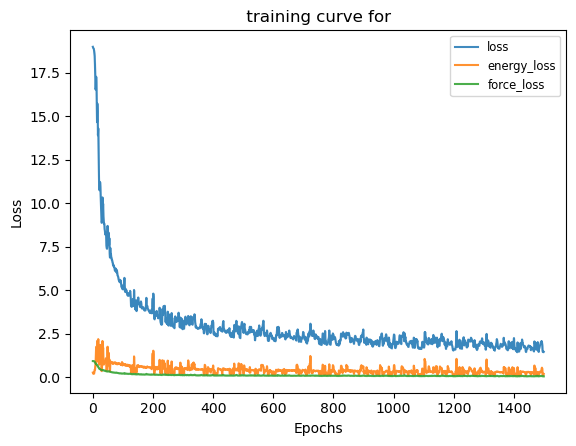

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.md.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates= "coords")],
    model_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, force="forces", atomic_number="nuclear_charges")]
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17469.426], dtype=float32),
 'forces': array([[-2.748085  ,  2.6256728 , -0.78267205],
        [-0.9930364 , -0.82697076,  2.0542693 ],
        [ 3.1510777 , -2.2085264 , -0.1802739 ],
        [-0.40241486,  1.6757585 , -0.07979959],
        [ 0.04864552,  1.7733607 ,  0.8525706 ],
        [-0.5403856 ,  0.3189385 , -0.15260887],
        [ 0.23556197,  0.68031883, -2.1317506 ],
        [-0.26164418, -1.3754804 , -0.1946038 ],
        [ 0.58718216,  3.9823062 ,  2.1114852 ],
        [-0.75260985,  2.133562  ,  0.6543348 ],
        [ 1.2029982 , -1.1586742 ,  0.5990734 ],
        [ 0.5796719 , -3.7986102 , -1.9712536 ],
        [ 1.8941513 , -1.0833018 , -0.7184192 ],
        [-0.2734214 , -0.56989604,  0.46630794],
        [ 1.1431112 , -1.7914355 ,  1.307971  ],
        [ 0.12865967,  0.17715025, -0.8077871 ],
        [-1.1630344 ,  0.40208864, -0.14888597],
        [-0.5132365 ,  0.4572237 , -0.17553854],
        [-0.30885172, -1.1101311 , -0.7465058 ],
        [-0.

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.md.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17469.426, dtype=float32), 'forces': array([[-2.748086  ,  2.6256735 , -0.7826708 ],
       [-0.9930364 , -0.82697105,  2.0542693 ],
       [ 3.1510777 , -2.2085257 , -0.18027455],
       [-0.40241522,  1.6757582 , -0.07979926],
       [ 0.0486443 ,  1.7733608 ,  0.8525707 ],
       [-0.54038644,  0.31893897, -0.15260935],
       [ 0.23556225,  0.68031824, -2.1317494 ],
       [-0.26164404, -1.3754799 , -0.19460437],
       [ 0.5871819 ,  3.9823077 ,  2.111486  ],
       [-0.7526098 ,  2.133562  ,  0.654335  ],
       [ 1.2029978 , -1.1586747 ,  0.5990733 ],
       [ 0.5796734 , -3.798612  , -1.9712542 ],
       [ 1.8941516 , -1.0833019 , -0.71841943],
       [-0.2734211 , -0.5698963 ,  0.46630812],
       [ 1.1431112 , -1.7914358 ,  1.3079714 ],
       [ 0.12865964,  0.17715043, -0.8077872 ],
       [-1.1630338 ,  0.40208817, -0.14888626],
       [-0.51323664,  0.45722383, -0.17553832],
       [-0.30885172, -1.1101311 , -0.74650574],
       [-0.486183  ,  0.3058204 ,

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.877eV  Ekin = 0.047eV (T=367K)  Etot = -831.830eV


Energy per atom: Epot = -831.895eV  Ekin = 0.066eV (T=512K)  Etot = -831.829eV
Energy per atom: Epot = -831.888eV  Ekin = 0.059eV (T=457K)  Etot = -831.829eV
Energy per atom: Epot = -831.870eV  Ekin = 0.043eV (T=329K)  Etot = -831.828eV
Energy per atom: Epot = -831.866eV  Ekin = 0.048eV (T=371K)  Etot = -831.818eV
Energy per atom: Epot = -831.881eV  Ekin = 0.060eV (T=467K)  Etot = -831.821eV
Energy per atom: Epot = -831.894eV  Ekin = 0.067eV (T=520K)  Etot = -831.826eV
Energy per atom: Epot = -831.888eV  Ekin = 0.061eV (T=475K)  Etot = -831.826eV
Energy per atom: Epot = -831.872eV  Ekin = 0.050eV (T=384K)  Etot = -831.823eV
Energy per atom: Epot = -831.879eV  Ekin = 0.052eV (T=402K)  Etot = -831.827eV
Energy per atom: Epot = -831.898eV  Ekin = 0.072eV (T=560K)  Etot = -831.825eV
Energy per atom: Epot = -831.891eV  Ekin = 0.068eV (T=525K)  Etot = -831.823eV
Energy per atom: Epot = -831.886eV  Ekin = 0.061eV (T=473K)  Etot = -831.825eV
Energy per atom: Epot = -831.888eV  Ekin = 0.066eV (